# MUSIC for Direction of Arrival

This notebook is a demo of MUSIC for Direction of Arrival

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
from scipy.signal import hilbert

import sys
sys.path.append("src")

from music import *
from music_advanced import *
from simulated_signal import *

from scipy.io import wavfile
import json

In [2]:
# Constants
w0 = np.pi / 5
fs = 2000

with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

room_dim = np.r_[10.,10.]
mics_coords = (microphone_2D_locations + room_dim / 2).T

# Baseline MUSIC implementation

We start by testing our implementation of MUSIC (found in the python files in the `src` folder) on our simulated data. It works well!  We can see what happens for different source distances, noise levels, mic distances and number of microphones.

## Different SNR values

In [3]:
def get_noise_var(snr, signal_var):
    temp = 10 ** (snr/10)
    return signal_var / temp

In [4]:
def get_samples(mic_distance, thetas, wavelength, n_mics, n_sources, n_samples, snr, noise_var=-1):
    phis = np.array([np.exp(-2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])
    A = np.vander(phis, n_mics, increasing=True).T
    S = np.random.normal(0, 1, (n_sources, n_samples))
    
    signal_var = np.var(S, axis=1).mean()
    
    noise_variance = get_noise_var(snr, signal_var) if noise_var == -1 else noise_var
    
    noise_matrix = np.random.normal(0, noise_variance, (n_mics, n_samples, 2)).view(np.complex128)\
                                        .reshape((n_mics, n_samples))

    return (A @ S) + noise_matrix

In [5]:
def plot_spectrum(freq_range, resolution, spectrums, labels, title, thetas, log=True, plot_theta=True):
    X = np.linspace(freq_range[0], np.pi/2, 10000)
    Y = [[spectrum(x) for x in X] for spectrum in spectrums]

    for i, y in enumerate(Y):
        plt.plot(X, y, label=labels[i], alpha=0.8)
    plt.legend()
    plt.xlabel('Angle (radians)')
    ylabel_log = '(log-scale)' if log else ''
    plt.ylabel(f'Spectrum {ylabel_log}')
    if log:
        plt.yscale('log')
    plt.title(title)
    
    if plot_theta:
        for theta in thetas:
            plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
            
    plt.show()

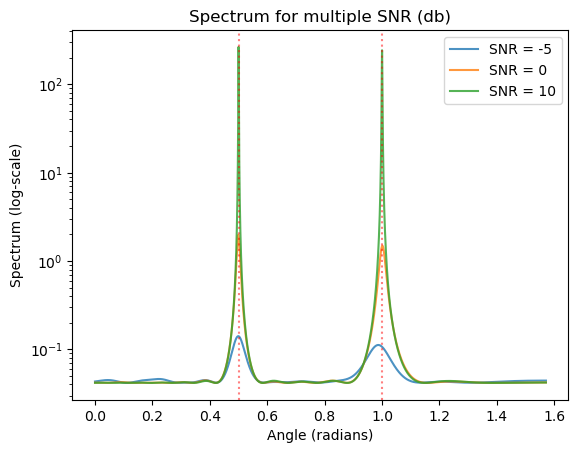

In [6]:
def plot_spectrum_different_snr(snr_values, wavelength, mic_distance=1, thetas=np.array([0.5, 1]), 
                                n_mics=24, n_samples=100):
    n_sources = len(thetas)
    samples_diff_var = []
    aligned_mics_coords = np.array([(0, mic_distance * i) for i in range(n_mics)]).T

    for snr in snr_values:
        samples = get_samples(mic_distance, thetas, wavelength, n_mics, n_sources, n_samples, snr=snr)
        samples_diff_var.append(samples)

    spectrums = [music(sampled_received, n_sources, aligned_mics_coords, main_frequency, verbose=False)
                 for sampled_received in samples_diff_var]

    labels = [f'SNR = {snr_value}' for snr_value in snr_values]
    plot_spectrum((0, np.pi/2), 10000, spectrums, labels, 'Spectrum for multiple SNR (db)', thetas, log=True)
    
main_frequency = (fs * w0) / (2 * np.pi)
wavelength = SOUND_SPEED / main_frequency
plot_spectrum_different_snr([-5, 0, 10], wavelength)

## Different angle distances values

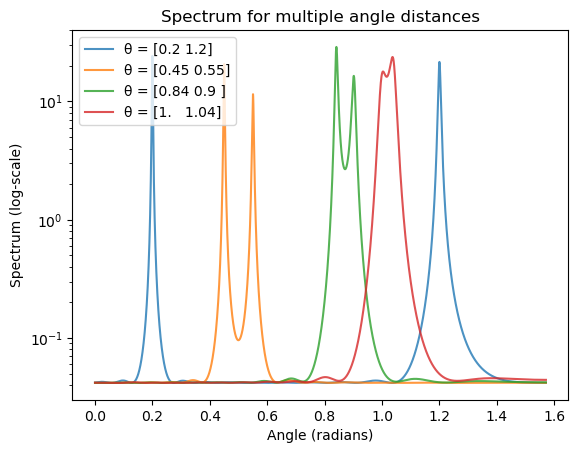

In [7]:
def plot_spectrum_different_angles(thetas, wavelength, mic_distance=1, n_mics=24, n_samples=100, snr=5):
    n_sources = thetas.shape[1]
    samples_diff_angles = []
    aligned_mics_coords = np.array([(0, mic_distance * i) for i in range(n_mics)]).T

    for angles in thetas:
        samples = get_samples(mic_distance, angles, wavelength, n_mics, n_sources, n_samples, snr=snr)
        samples_diff_angles.append(samples)

    spectrums = [music(sampled_received, n_sources, aligned_mics_coords, main_frequency, verbose=False)
                 for sampled_received in samples_diff_angles]

    labels = [f'θ = {theta}' for theta in thetas]
    plot_spectrum((0, np.pi/2), 10000, spectrums, labels, 'Spectrum for multiple angle distances', thetas,
                  log=True, plot_theta=False)
    
plot_spectrum_different_angles(np.array([[0.2, 1.2], [0.45, 0.55], [0.84, 0.9], [1.0, 1.04]]), wavelength)

## Different microphone distances

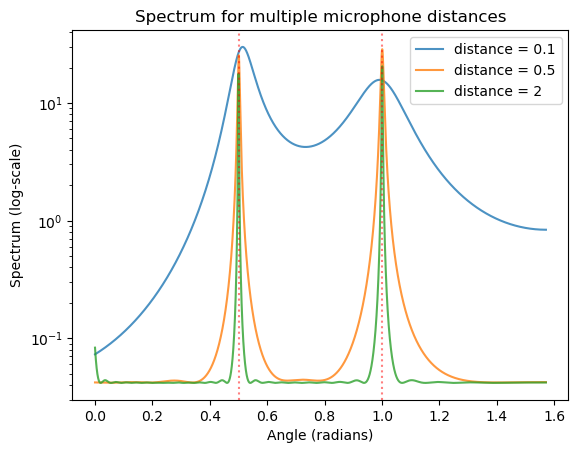

In [8]:
def plot_spectrum_different_mic_distance(mic_distances, wavelength, thetas=np.array([0.5, 1]),
                                   n_mics=24, n_samples=100, snr=5):
    n_sources = len(thetas)
    samples_diff_distance = []
    spectrums = []
    
    for mic_distance in mic_distances:
        sampled_received = get_samples(mic_distance, thetas, wavelength, n_mics, n_sources, n_samples, snr=snr)
        aligned_mics_coords = np.array([(0, mic_distance * i) for i in range(n_mics)]).T
        spectrum = music(sampled_received, n_sources, aligned_mics_coords, main_frequency, verbose=False)
        spectrums.append(spectrum)

    labels = [f'distance = {mic_distance}' for mic_distance in mic_distances]
    plot_spectrum((0, np.pi/2), 10000, spectrums, labels, 'Spectrum for multiple microphone distances',
                  thetas, log=True)
    
plot_spectrum_different_mic_distance([0.1, 0.5, 2], wavelength)

## Different number of microphone

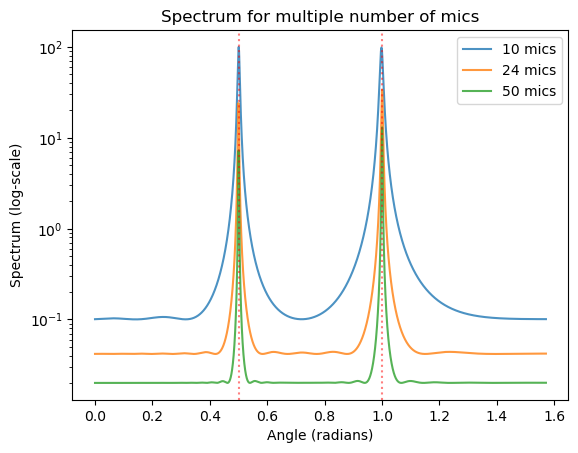

In [9]:
def plot_spectrum_different_nb_mics(n_mics_array, wavelength, mic_distance=1, thetas=np.array([0.5, 1]),
                                   n_samples=100, snr=5):
    n_sources = len(thetas)
    samples_diff_nb_mics = []
    spectrums = []

    for n_mics in n_mics_array:
        aligned_mics_coords = np.array([(0, mic_distance * i) for i in range(n_mics)]).T
        samples = get_samples(mic_distance, thetas, wavelength, n_mics, n_sources, n_samples, snr=snr)
        spectrum = music(samples, n_sources, aligned_mics_coords, main_frequency, verbose=False)
        spectrums.append(spectrum)
        
    labels = [f'{n_mics} mics' for n_mics in n_mics_array]
    plot_spectrum((0, np.pi/2), 10000, spectrums, labels, 'Spectrum for multiple number of mics', thetas, log=True)
    
plot_spectrum_different_nb_mics([10, 24, 50], wavelength)

## Correlated sources

$A_{m, k}=e^{-j \frac{2\pi}{\lambda} (x_m\cos(\theta_k)+y_m\sin(\theta_k))}$

In [10]:
def get_samples_correlated_sources(coords, thetas, wavelength, n_mics, n_sources, n_samples, noise_var):
    A = np.zeros((n_mics, n_sources), dtype='complex_')
    for m in range(n_mics):
        for k in range(n_sources):
            distance = coords[0, m]*np.cos(thetas[k])+coords[1, m]*np.sin(thetas[k])
            A[m, k] = np.exp(-2j * np.pi * distance / wavelength)
    
    S = np.zeros((n_sources, n_samples))
    
    S[0] = np.random.normal(0, 1, (1, n_samples))
    S[2] = np.random.normal(0, 1, (1, n_samples))
    S[1] = 0.5*S[0]+2*S[2]
    S[3] = np.random.normal(0, 1, (1, n_samples))
    
    noise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128)\
                                        .reshape((n_mics, n_samples))
    return (A @ S) + noise_matrix

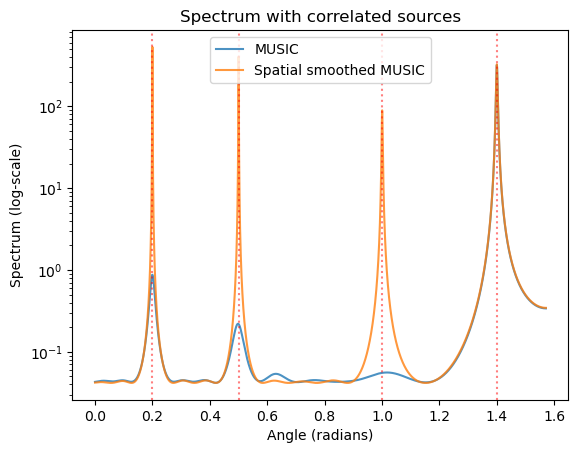

In [11]:
def plot_correlated_sources(thetas, wavelength, coords, n_mics=24):
    n_sources = len(thetas)
    n_samples = 10000

    corr_samples = get_samples_correlated_sources(coords, thetas, wavelength, n_mics,\
                                                  n_sources, n_samples, noise_var=1)
    names = ['MUSIC', 'Spatial smoothed MUSIC']
    
    spectrums = [music(corr_samples, n_sources, coords, main_frequency, verbose=False),
            music(corr_samples, n_sources, coords, main_frequency, correlated=True, verbose=False)]

    plot_spectrum((0, np.pi/2), 10000, spectrums, names, 'Spectrum with correlated sources', thetas, log=True)
    

dist = 1
n_mics = 24
# Or : np.array([(dist*np.cos(i)*2*np.pi/n_mics, dist*np.sin(i)*2*np.pi/n_mics) for i in range(n_mics)]).T
aligned_mics_coords = np.array([(0, dist * i) for i in range(n_mics)]).T 
plot_correlated_sources([0.2, 0.5, 1, 1.4], wavelength, aligned_mics_coords, n_mics=n_mics)

# Real(-valued) data

In [12]:
fs_real, data = wavfile.read('last_year/fq_sample3_spkr0_angle70.wav')
data = data[:, top_mics].T
angle_rad = 70 / 180 * np.pi # should be adapted based on "angleXX" in file name

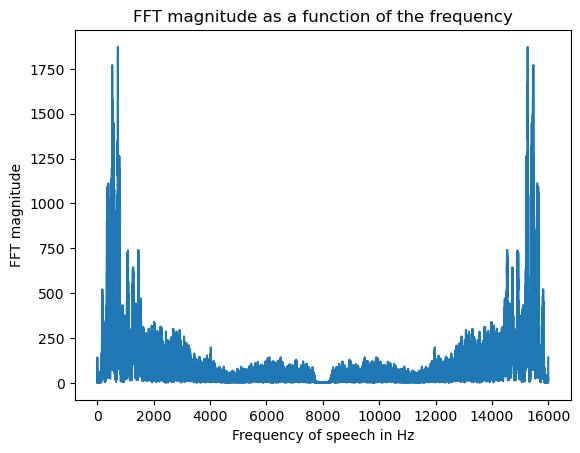

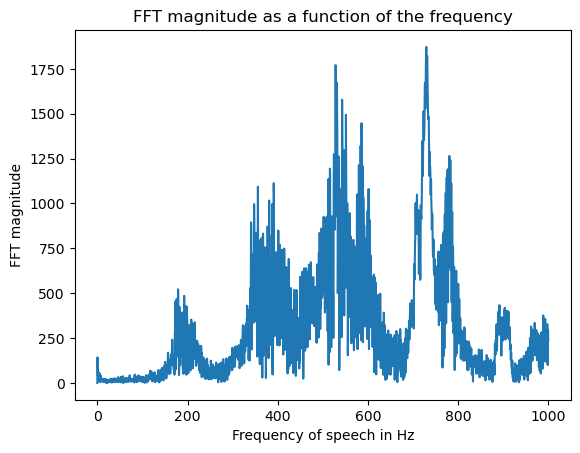

In [13]:
normalized_data = (data[0] - np.mean(data[0])) / np.std(data[0])

fft = np.fft.fft(normalized_data)
frequencies = np.linspace(0, fs_real, len(fft))

plt.plot(frequencies, abs(fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

selected_ids = np.argwhere(frequencies < 1000)
selected_freq = frequencies[selected_ids]
selected_fft = fft[selected_ids]

plt.plot(selected_freq, abs(selected_fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

Samples shape: (24, 37885)
Covariance shape: (24, 24)


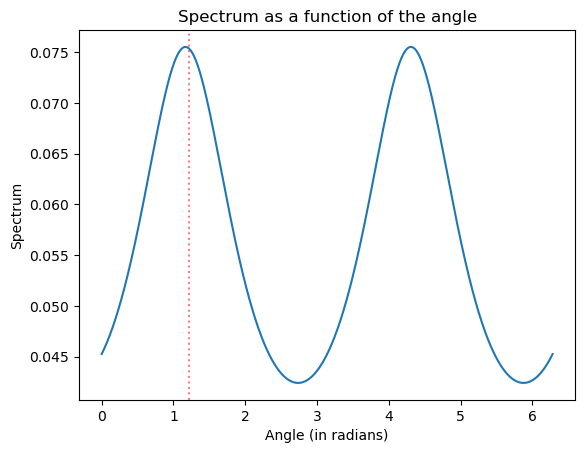

In [14]:
main_frequency_real_data = 600
spectrum = music(data, 1, mics_coords, main_frequency_real_data) 

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
plt.xlabel('Angle (in radians)')
plt.ylabel('Spectrum')
plt.title('Spectrum as a function of the angle')
plt.axvline(x=angle_rad, color='red', linestyle=':', alpha=0.5)
plt.show()

In [15]:
estimated_theta = extract_frequencies(spectrum, 1, [0, np.pi / 2])[0]
print(f'estimated angle in radians = {estimated_theta:.4f}, and in degrees = {estimated_theta/np.pi*180}')
print(f'true      angle in radians = {angle_rad:.4f}, and in degrees = {angle_rad/np.pi*180}')

estimated angle in radians = 1.1666, and in degrees = 66.84300000000002
true      angle in radians = 1.2217, and in degrees = 70.0


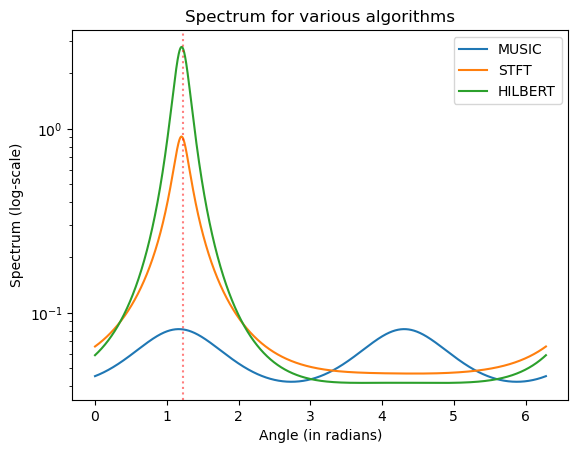

In [16]:
main_frequency_real_data = 650

stft = music_with_frequency(data, 1, fs_real, mics_coords, segment_duration=1, freq_range=[0, 1200], verbose=False)
music_spectrum = music(data, 1, mics_coords, main_frequency_real_data, verbose=False) 
hilbert = music(hilbert(data).conj(), 1, mics_coords, main_frequency_real_data, verbose=False) 

X = np.linspace(0, 2 * np.pi, 10000)

plt.plot(X, [music_spectrum(x) for x in X], label='MUSIC')
plt.plot(X, [stft(x) for x in X], label='STFT')
plt.plot(X, [hilbert(x) for x in X], label='HILBERT')
plt.yscale('log')
plt.xlabel('Angle (in radians)')
plt.ylabel('Spectrum (log-scale)')
plt.title('Spectrum for various algorithms')
plt.legend()
plt.axvline(x=angle_rad, color='red', linestyle=':', alpha=0.5)
plt.show()

In [17]:
print('music  ', extract_frequencies(music_spectrum, 1, [0, np.pi/2]))
print('stft   ', extract_frequencies(stft, 1, [0, np.pi/2]))
print('hilbert', extract_frequencies(hilbert, 1, [0, np.pi/2]))
print('real   ', angle_rad)

music   [1.16694459]
stft    [1.20495786]
hilbert [1.20668574]
real    1.2217304763960306
